In [23]:
import torch 
import numpy as np 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 


from tqdm import trange
from dgl.nn import GraphConv 

import networkx as nx

import torch 
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx

import matplotlib.pyplot as plt 
import warnings

from dgl.data import CoraGraphDataset

warnings.filterwarnings('ignore')
%matplotlib inline

$\text{Node : }$ 머신러닝 논문

$\text{Edge : }$ 논문 쌍 간의 인용

$\text{Feature : }$ 노드 $\text{Feature}$의 수

$\text{Classes : }$ 논문 라벨링 0~6

In [6]:
# CoraGraphDataset -> citation network.
dataset = CoraGraphDataset()
g = dataset[0]

features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
test_mask = g.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [7]:
u, v = g.all_edges()
graph_edge = torch.stack([u, v]).long()
num_nodes = features.shape[0]

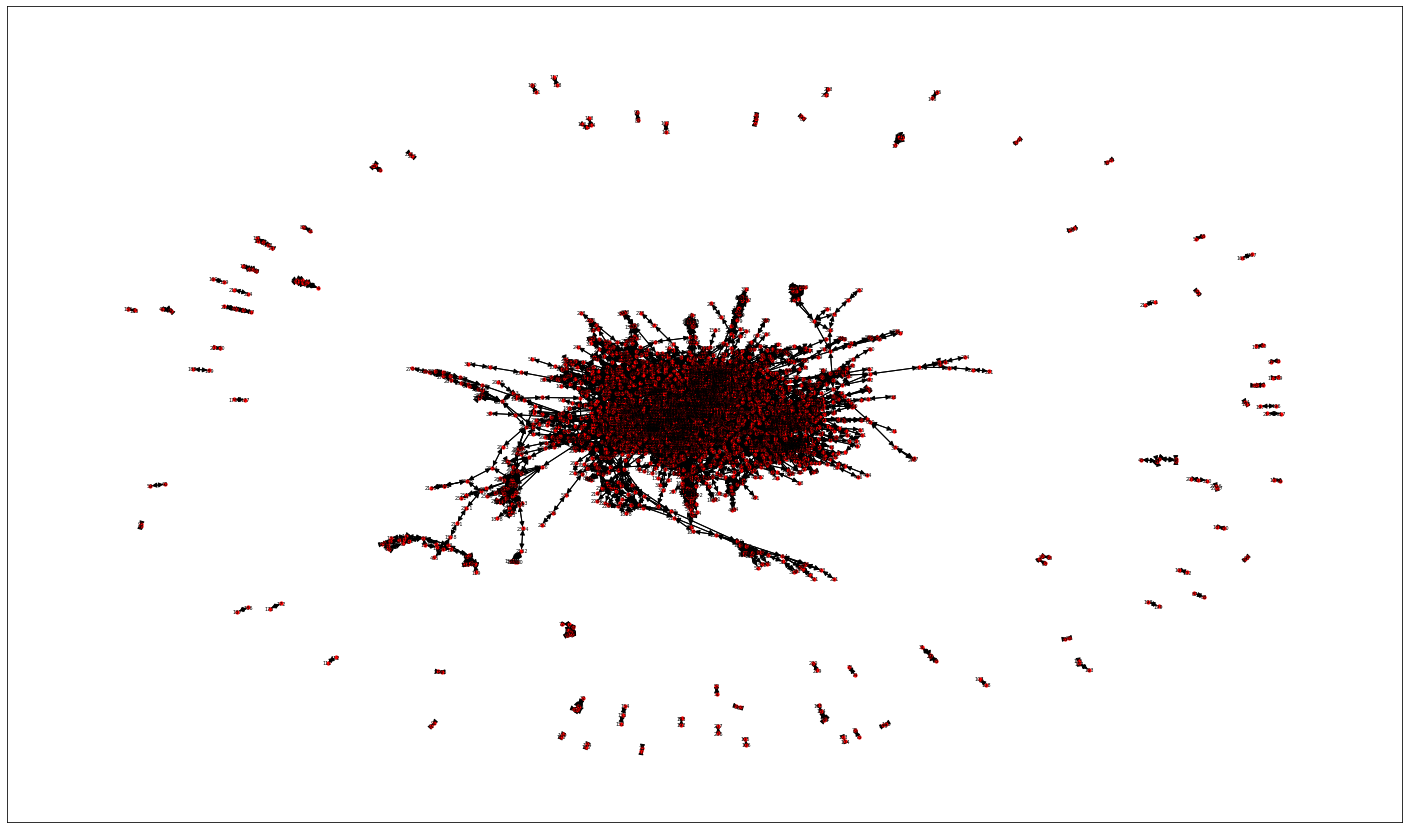

In [59]:
Graph = Data(edge_index = graph_edge, num_nodes=num_nodes)
G = to_networkx(Graph)
fig, axes = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, node_size = 10, node_color='red', font_size=5)

In [8]:
num_features = features.shape[1] # N * F
hidden_dim = 64 
output_dim = 7
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### $$ \tilde{A} = A + I $$
### $$ \tilde{D}_{ii} = \sum_j A_{ij} $$
### $$ \hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} \text{: Laplacian normalization}$$
$ \ $
  
### $$ x_1 = \text{ReLU}(\hat{A} X W^{(0)} + b^{(0)}) $$
### $$ x_2 = ( \hat{A} x_1 W^{(1)} + b^{(1)}) $$
$x_1, x_2$는 각각 첫 번째, 두 번째 Convolution을 의미한다. 

$\text{ReLU}$는 $\text{activation function}$을 의미한다.


![graphconv_pic1](figure/graphconv_pic1.JPG)

In [9]:
class SimpleGraphConv(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(SimpleGraphConv, self).__init__()
        self.layer1 = GraphConv(num_features, hidden_dim, norm='both') # activation default=None 
        self.layer2 = GraphConv(hidden_dim, output_dim, norm='both') # activation defalut=None
        self.relu = nn.ReLU()
        
    def forward(self, g, features):
        x1 = self.layer1(g, features)
        x1 = self.relu(x1)
        x2 = self.layer2(g, x1)
        return x2 

In [10]:
models = SimpleGraphConv(num_features, hidden_dim, output_dim)
optimizer = optim.Adam(models.parameters(), lr = 1e-2)

criterion = nn.CrossEntropyLoss()

def calc_accuracy(pred, label, mask):
    pred = pred[mask]
    label = label[mask]
    pred = torch.argmax(pred, dim=-1)
    correct = (pred == label).sum()
    return (correct.item() / len(label)) * 100 

### $$y * \log (\text{softmax}(z)) = \text{cross entropy}$$
### $$\text{cross entropy = log softmax + nll loss}$$
### $$\text{nll loss : Negative Likelihood}$$

In [11]:
# self-connection 
print(f'number of edges, before self-connection :{g.num_edges()}')
g.add_edge(g.nodes(), g.nodes()) # or g.add_self_loop()
print(f'number of edges, after self-connection :{g.num_edges()}')

# GCN을 제안한 논문에서는 Node Classification을 수행할 때 Label된 Node들만 propagation rule을 적용하기 때문에 labeling된 loss 값만 가지고 back-propagation을 수행한다. 

number of edges, before self-connection :10556
number of edges, after self-connection :13264


In [12]:
train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []
with trange(num_epochs) as tr:
    for i in tr:
        
        models.train()
        optimizer.zero_grad()
        pred = models(g, features)
        loss = criterion(pred[train_mask], labels[train_mask]) # 둘 중 하나 아무거나 사용해도 무방.
#       logp = F.log_softmax(pred, dim=-1)
#       loss = F.nll_loss(logp[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()
        
        train_loss = loss.detach().item()
        train_acc = calc_accuracy(pred, labels, train_mask)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        if (i+1) % 10 == 0:
            print(f'epoch [{i+1}/{num_epochs}]\n train loss: {train_loss:.4f}\t train acc: {train_acc:.2f}%')
        
        
        models.eval()
        with torch.no_grad():
            pred = models(g, features)
            test_loss = criterion(pred[test_mask], labels[test_mask])
            test_acc = calc_accuracy(pred, labels, test_mask)
            
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            
            if (i+1) % 10 == 0 :
                print(f' test loss: {test_loss:.4f}\t test acc: {test_acc:.2f}% \n')

  6%|▌         | 12/200 [00:00<00:07, 24.80it/s]

epoch [10/200]
 train loss: 1.6519	 train acc: 91.43%
 test loss: 1.7674	 test acc: 70.30% 



 12%|█▏        | 24/200 [00:00<00:07, 24.32it/s]

epoch [20/200]
 train loss: 1.0625	 train acc: 98.57%
 test loss: 1.4020	 test acc: 79.80% 



 16%|█▋        | 33/200 [00:01<00:07, 22.01it/s]

epoch [30/200]
 train loss: 0.4919	 train acc: 98.57%
 test loss: 1.0052	 test acc: 81.20% 



 21%|██        | 42/200 [00:01<00:06, 23.75it/s]

epoch [40/200]
 train loss: 0.1941	 train acc: 99.29%
 test loss: 0.7645	 test acc: 81.10% 



 27%|██▋       | 54/200 [00:02<00:06, 23.97it/s]

epoch [50/200]
 train loss: 0.0819	 train acc: 100.00%
 test loss: 0.6768	 test acc: 80.50% 



 32%|███▏      | 63/200 [00:02<00:05, 24.44it/s]

epoch [60/200]
 train loss: 0.0415	 train acc: 100.00%
 test loss: 0.6555	 test acc: 80.30% 



 36%|███▌      | 72/200 [00:03<00:05, 24.21it/s]

epoch [70/200]
 train loss: 0.0254	 train acc: 100.00%
 test loss: 0.6531	 test acc: 80.10% 



 42%|████▏     | 84/200 [00:03<00:05, 23.00it/s]

epoch [80/200]
 train loss: 0.0177	 train acc: 100.00%
 test loss: 0.6556	 test acc: 80.10% 



 46%|████▋     | 93/200 [00:03<00:04, 22.94it/s]

epoch [90/200]
 train loss: 0.0134	 train acc: 100.00%
 test loss: 0.6587	 test acc: 79.60% 



 51%|█████     | 102/200 [00:04<00:04, 23.01it/s]

epoch [100/200]
 train loss: 0.0108	 train acc: 100.00%
 test loss: 0.6634	 test acc: 79.40% 



 57%|█████▋    | 114/200 [00:04<00:03, 23.00it/s]

epoch [110/200]
 train loss: 0.0089	 train acc: 100.00%
 test loss: 0.6677	 test acc: 79.50% 



 62%|██████▏   | 123/200 [00:05<00:03, 22.75it/s]

epoch [120/200]
 train loss: 0.0076	 train acc: 100.00%
 test loss: 0.6726	 test acc: 79.50% 



 66%|██████▌   | 132/200 [00:05<00:02, 23.26it/s]

epoch [130/200]
 train loss: 0.0066	 train acc: 100.00%
 test loss: 0.6771	 test acc: 79.30% 



 72%|███████▏  | 144/200 [00:06<00:02, 22.32it/s]

epoch [140/200]
 train loss: 0.0057	 train acc: 100.00%
 test loss: 0.6815	 test acc: 79.10% 



 76%|███████▋  | 153/200 [00:06<00:02, 22.84it/s]

epoch [150/200]
 train loss: 0.0051	 train acc: 100.00%
 test loss: 0.6859	 test acc: 78.80% 



 81%|████████  | 162/200 [00:07<00:01, 21.85it/s]

epoch [160/200]
 train loss: 0.0045	 train acc: 100.00%
 test loss: 0.6903	 test acc: 78.80% 



 87%|████████▋ | 174/200 [00:07<00:01, 21.30it/s]

epoch [170/200]
 train loss: 0.0041	 train acc: 100.00%
 test loss: 0.6948	 test acc: 78.80% 



 92%|█████████▏| 183/200 [00:08<00:00, 21.92it/s]

epoch [180/200]
 train loss: 0.0037	 train acc: 100.00%
 test loss: 0.6989	 test acc: 78.60% 



 96%|█████████▌| 192/200 [00:08<00:00, 21.07it/s]

epoch [190/200]
 train loss: 0.0033	 train acc: 100.00%
 test loss: 0.7029	 test acc: 78.50% 



100%|██████████| 200/200 [00:08<00:00, 22.58it/s]

epoch [200/200]
 train loss: 0.0030	 train acc: 100.00%
 test loss: 0.7068	 test acc: 78.50% 



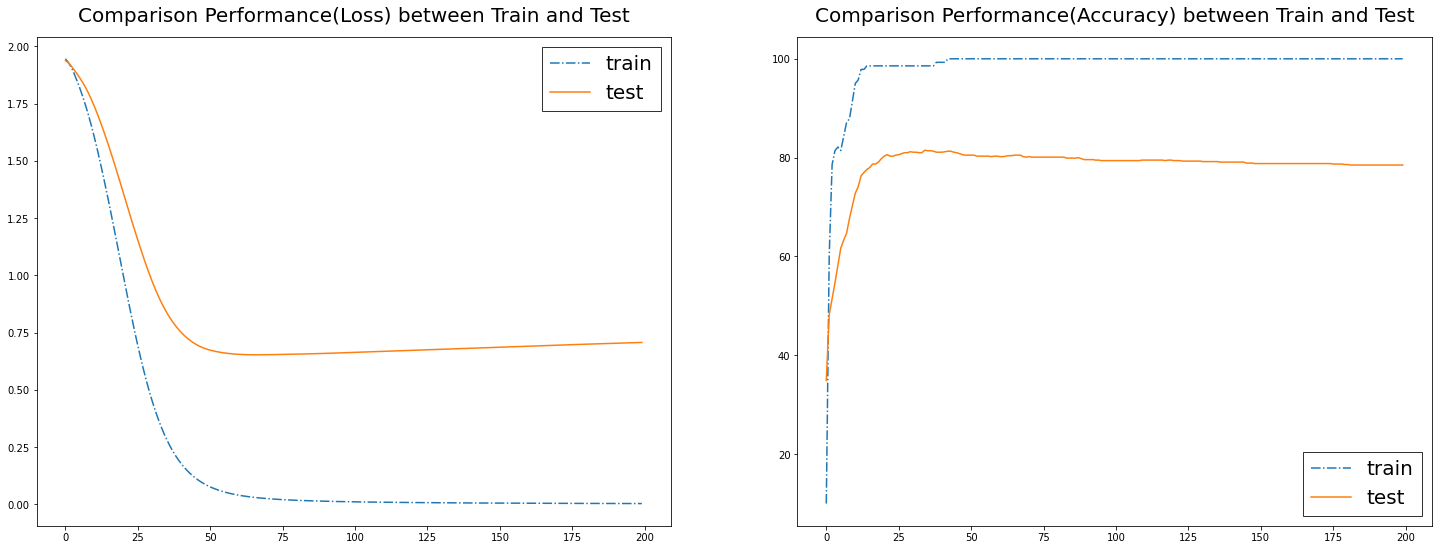

In [63]:
k = np.arange(num_epochs)
results = dict({
    'train':[train_loss_list, train_acc_list], 
    'test':[test_loss_list, test_acc_list]
})

fig, aes = plt.subplots(nrows=1,ncols=2, figsize = (25, 9))
for i, ax in enumerate(aes):
    ax.plot(k, results['train'][i], linestyle='-.', label='train')
    ax.plot(k, results['test'][i], linestyle='-', label='test')
    ax.legend(fontsize=20, fancybox=False, edgecolor='black')
    if i == 0:
        ax.set_title('Comparison Performance(Loss) between Train and Test', size=20, pad=15)
    else:
        ax.set_title('Comparison Performance(Accuracy) between Train and Test', size=20, pad=15)
    